# iris tomography codes and other stuff

In [1]:
import sqlite3 as sql
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

# import data from database

In [2]:
orbit = 20900
num_of_orbits = 2
ch = 3

db = sql.connect('/home/anqil/Documents/Python/iris_git/OSIRIS_three_orbits_test.db')
cur = db.cursor()

return_column = ('data, mjd, look_ecef, sc_position_ecef, latitude, longitude, altitude')              
select_str = 'SELECT {} FROM IRI JOIN channel{} ON IRI.stw = channel{}.stw WHERE orbit>={} AND orbit<={}'
result = cur.execute(select_str.format(return_column, ch, ch, orbit, orbit+num_of_orbits))
all_image = result.fetchall()
db.close()

if len(all_image) == 0:
    print('No data for this orbit(s)')
    

print('num of images: {}'.format(len(all_image)))

l1_blob = np.array(all_image)[:,0]
mjd = np.array(all_image)[:,1].astype(float)
date = num2date(mjd, units)
sc_look_blob = np.array(all_image)[:,2]
sc_pos_blob = np.array(all_image)[:,3]
tan_lat_blob = np.array(all_image)[:,4]
tan_lon_blob = np.array(all_image)[:,5]
tan_alt_blob = np.array(all_image)[:,6]

#====unfolding blobs
l1 = np.empty((len(all_image),128))
sc_look = np.empty((len(all_image), 128, 3))
sc_pos = np.empty((len(all_image), 3))
tan_lat = np.empty((len(all_image),128))
tan_lon = np.empty((len(all_image),128))
tan_alt = np.empty((len(all_image),128))
for i in range(len(all_image)):
    l1[i,:] = np.frombuffer(l1_blob[i])
    sc_look[i,:,:] = np.frombuffer(sc_look_blob[i]).reshape(128,3)
    sc_pos[i,:] = np.frombuffer(sc_pos_blob[i])
    tan_lat[i,:] = np.frombuffer(tan_lat_blob[i])
    tan_lon[i,:] = np.frombuffer(tan_lon_blob[i])
    tan_alt[i,:] = np.frombuffer(tan_alt_blob[i])
#====construct xarray data array
pixel = np.arange(128)
l1 = xr.DataArray(l1, coords=(date, pixel), 
                  dims=('date', 'pixel'), 
                  attrs={'units':'Rayleigh??'})
sc_look = xr.DataArray(sc_look, coords=(date, pixel, ['x', 'y', 'z']), 
                       dims=('date', 'pixel', 'xyz'))
sc_pos = xr.DataArray(sc_pos, coords=(date, ['x', 'y', 'z']), dims=('date', 'xyz'))
tan_lat = xr.DataArray(tan_lat, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_lon = xr.DataArray(tan_lon, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_alt = xr.DataArray(tan_alt, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'meter'})



num of images: 8695


# 1D interpolation and plotting limb radiance

/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


<Figure size 432x288 with 0 Axes>

/home/anqil/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


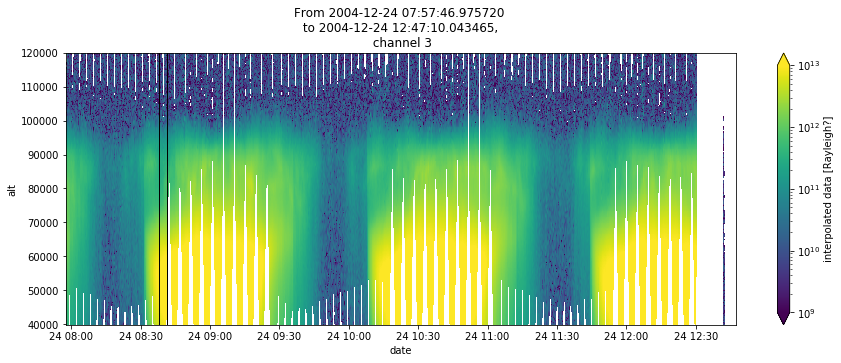

<Figure size 432x288 with 0 Axes>

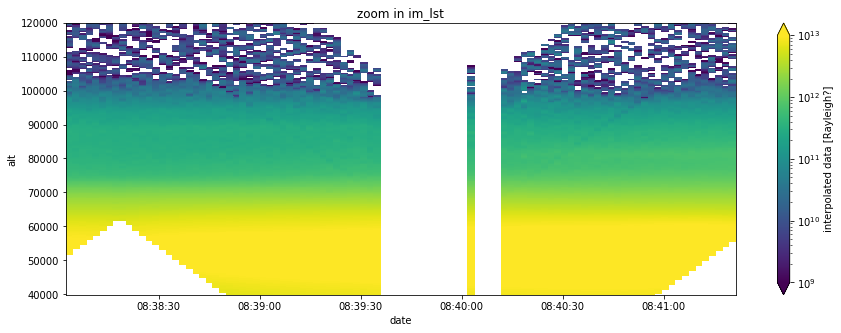

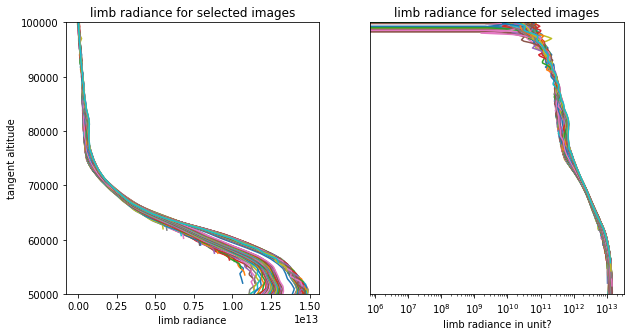

In [3]:
# choose some images to focus
im_lst = np.arange(1200, 1300)

alts_interp = np.arange(40e3, 120e3, .25e3)
data_interp = []

for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=(date, alts_interp), 
                           dims=('date', 'alt'))
data_interp.attrs['units'] = 'Rayleigh?'
data_interp.attrs['long_name'] = 'interpolated data'

#FIG_SIZE = (15,6)
plt.figure()
data_interp.plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='From {} \n to {}, \n channel {}'.format(num2date(mjd[0],units),
       num2date(mjd[-1], units), ch))
plt.axvline(x=date[im_lst[0]], color='k', linewidth=1)
plt.axvline(x=date[im_lst[-1]], color='k', linewidth=1)
plt.show()

plt.figure()
data_interp.isel(date=im_lst).plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])

plt.subplot(122)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(xlabel='limb radiance in unit?',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])
ax.set_xscale('log')
plt.yticks([])
plt.show()

# 1D inversion for O2(1 delta) volumn emission rate


[Text(0, 0.5, 'altitdue grid'),
 (10000.0, 10000000.0),
 Text(0.5, 0, 'volumn emission rate photons cm-3 s-1'),
 Text(0.5, 1.0, '1d retrieval')]

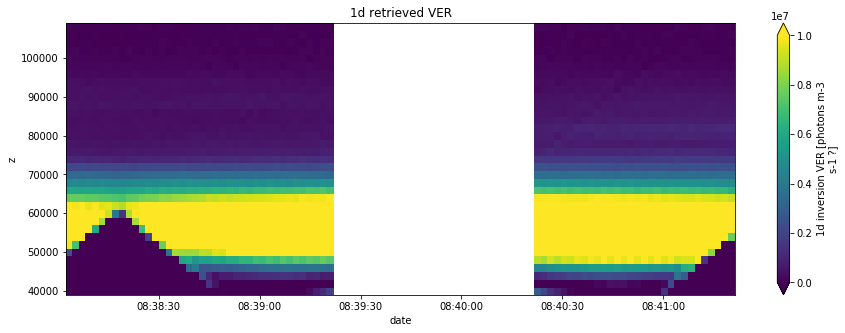

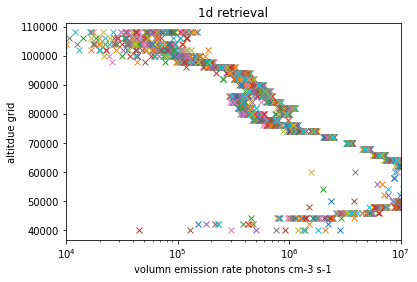

In [4]:
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris

z = np.arange(40e3, 110e3, 2e3) # m
z_top = z[-1] + 2e3
result_1d = np.zeros((len(im_lst), len(z)))
xa = np.ones(len(z)) # temp
Sa = np.diag(np.ones(len(z))) *1e-9 #temp
Se = np.diag(np.ones(len(pixel))) * 30# 1e10 #30 #temporary
for i in range(len(im_lst)):
    h = tan_alt.isel(date=im_lst[i]).data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(date=im_lst[i]).data    
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
#    plt.plot(y, np.arange(128))
#    plt.plot(K.dot(x), np.arange(128))

result_1d = xr.DataArray(result_1d, coords=(date[im_lst], z), dims=('date', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'

# plot VER results
result_1d.plot(x='date', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=1e7, 
         size=5, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER')

plt.figure()
plt.plot(result_1d.T, z, 'x')
ax = plt.gca()
ax.set_xscale('log')
ax.set(xlim=[1e4, 1e7],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')

# Ozone

Text(0.5, 1.0, 'gA')

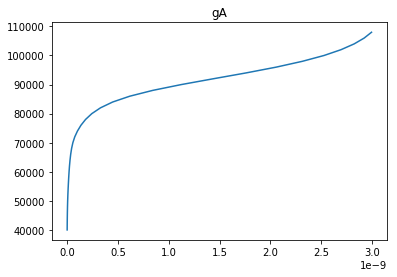

In [5]:
from chemi import ozone_sme, ozone_textbook, oxygen_atom, jfactors, gfactor
from scipy.io import loadmat
import sys
sys.path.append('..')
MSIS = loadmat('../msisdata.mat')
zMsis = MSIS['zMsis'].squeeze() # in km
TMsis = MSIS['TMsis'] # in K
NMsis = MSIS['NMsis'] # in cm-3 ???
monthMsis = MSIS['monthMsis'].squeeze()
latMsis = MSIS['latMsis'].squeeze()
month = 6 #temp
lat = 1 #temp
T = interp1d(zMsis*1e3, TMsis[:,month,lat], fill_value='extrapolate')(z)
M = interp1d(zMsis*1e3, NMsis[:,month,lat], fill_value='extrapolate')(z)

#calculate O2 photosythesis rate first
zenithangle = 10
gA = gfactor(0.2*M, T, z, zenithangle)
plt.plot(gA,z)
plt.title('gA')


[(40000.0, 100000.0),
 Text(0, 0.5, 'altitude grid'),
 (1000000.0, 1000000000000.0),
 Text(0.5, 0, 'ozone number density / cm-3'),
 Text(0.5, 1.0, 'ozone from 1d retrieval')]

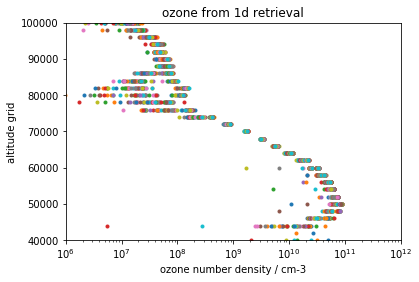

In [6]:
# with constant Jhart to calculate ozone for images within im_lst
o3 = ozone_sme(M, T, result_1d, jhart=8e-3)
plt.figure()
ax = plt.subplot()
ax.plot(o3.T, z, '.')
ax.set_xscale('log')
ax.set(xlabel='ozone number density / cm-3',
       ylabel='altitude grid',
       title='ozone from 1d retrieval',
       xlim=[1e6,1e12],
       ylim=[40e3, 100e3])


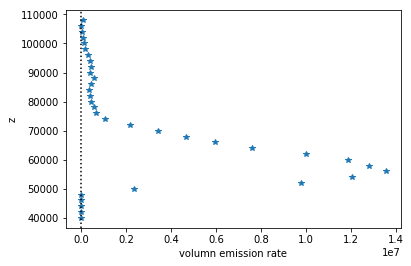

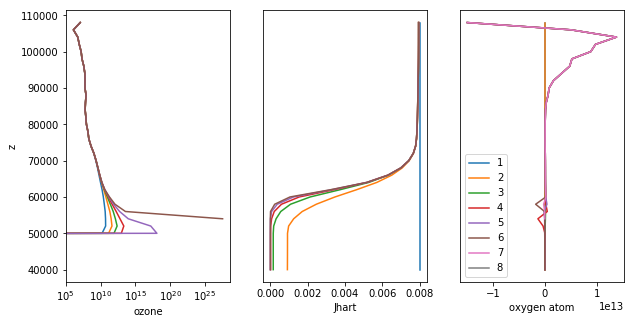

In [8]:
plt.figure()
plt.plot(result_1d[0],z, '*')
plt.axvline(x=0, linestyle=':', color='k')
plt.xlabel('volumn emission rate')
plt.ylabel('z')

plt.figure(figsize=(10, 5))
ax0 = plt.subplot(131)
ax1 = plt.subplot(132)
ax2 = plt.subplot(133)
ax1.set_yticks([])
ax2.set_yticks([])
ax0.set(xlabel='ozone', 
        ylabel='z')#,
#        xlim=[0, 1e11])
ax0.set_xscale('log')
ax1.set(xlabel='Jhart')
ax2.set(xlabel='oxygen atom')

#iter 1

o3 = ozone_sme(M, T, result_1d[0], jhart=8e-3, js=gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=8e-3)
ax0.plot(o3,z, label='1')
ax1.plot(8e-3 * np.ones(z.shape), z, label='1')
ax2.plot(0*np.ones(z.shape), z, label='1')
plt.legend()

#iter 2
jhart, jsrc, jlya, j3, j2 = jfactors(O=0*M, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='2')
ax1.plot(jhart, z, label='2')
ax2.plot(0*np.ones(z.shape), z, label='2')
plt.legend()

#iter 3
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=o.data, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='3')
ax1.plot(jhart, z, label='3')
ax2. plot(o, z, label='3')
plt.legend()

#iter 4
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=o.data, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='4')
ax1.plot(jhart, z, label='4')
ax2. plot(o, z, label='4')
plt.legend()

#iter 5
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=o.data, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='5')
ax1.plot(jhart, z, label='5')
ax2. plot(o, z, label='5')
plt.legend()

#iter 6
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=o.data, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='6')
ax1.plot(jhart, z, label='6')
ax2. plot(o, z, label='6')
plt.legend()

#iter 7
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=o.data, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='7')
ax1.plot(jhart, z, label='7')
ax2. plot(o, z, label='7')
plt.legend()

#iter 8
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=o.data, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='8')
ax1.plot(jhart, z, label='8')
ax2. plot(o, z, label='8')
plt.legend()

